# import

In [0]:
!pip install keras-bert
!pip install keras-radam

In [0]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [0]:
path = '/content/drive/My Drive'

In [0]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-04-22 14:03:16--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 2607:f8b0:4001:c1e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.3’

multi_cased_L-12_H- 100%[===================>] 632.19M  57.6MB/s    in 11s     

2020-04-22 14:03:27 (59.7 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.3’ saved [662903077/662903077]



In [0]:
os.listdir('bert')

['multi_cased_L-12_H-768_A-12',
 'bert_model.ckpt.meta',
 'vocab.txt',
 'bert_model.ckpt.index',
 'bert_config.json',
 'bert_model.ckpt.data-00000-of-00001']

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers
from keras.utils import to_categorical
from keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

import codecs
from tqdm import tqdm
import shutil

from IPython.display import SVG

import time


# 데이터 로드 및 처리

In [0]:
df = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/딥러닝/glowpick_end.csv')
df.head()

product  ...                                              index
0  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...  [753, 7, 75, 40, 234, 1561, 361, 370, 60, 714,...
1  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...  [39, 18, 491, 228, 173, 42, 36, 7, 531, 686, 5...
2  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...       [44, 46, 144, 51, 163, 4856, 127, 188, 1142]
3  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...  [937, 145, 78, 44, 46, 144, 424, 108, 3, 1237,...
4  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...  [27, 41, 184, 1, 186, 288, 110, 998, 44, 46, 1...

[5 rows x 12 columns]

In [0]:
#############긍/부정 mapping
# 1:긍정, 0:부정
rating_mapping = {5:1, 4:1, 3:0, 2:0, 1:0} 
df['label'] = df['rating'].map(rating_mapping)

In [0]:
df.head()

product  ... label
0  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     3
1  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     3
2  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     3
3  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     3
4  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     3

[5 rows x 13 columns]

In [0]:
#to_categorical 함수는 max값으로 카테고리 몇개있는지 인식하고 0부터 인식하기 때문에, 1~5있으면 6개 category있는 걸로 오해함.
#df['label'] = df['rating']-1

In [0]:
df.dropna(axis=0, how='any',inplace=True)

In [0]:
df.head()

product  ... label
0  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
1  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
2  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
3  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1
4  소프트 에어리 UV 에센스 [SPF50+/PA++++]  ...     1

[5 rows x 13 columns]

In [0]:
y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.2, random_state=99, shuffle=True, stratify=y_train)

In [0]:
SEQ_LEN = 128

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "pre_review"
LABEL_COLUMN = "label"

In [0]:
def convert_data(data_x, data_y):
    # make indices
    col_index = data_x.columns.get_loc("index")
    indices=[]

    for i in range(len(data_x)):
      a = data_x.iloc[i, col_index]
      b = a.strip('[]')
      c = b.split(',')
      blank_list = []
      for j in range(SEQ_LEN):
        try:
            num = float(c[j])
        except:
            num=0
        blank_list.append(num)
      indices.append(blank_list)
        
    print(indices)
    targets = data_y
    items = list(zip(indices, targets))
    indices, targets = zip(*items)
    targets = to_categorical(targets,2)  # 이부분 개수 ㅠ
    indices = np.asarray(indices)
    
    return [indices, np.zeros_like(indices)], np.array(targets)

- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [0]:
train_x, train_y = convert_data(X_train, y_train)
val_x, val_y = convert_data(X_val, y_val)
test_x, test_y = convert_data(X_test, y_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
train_x

[array([[  27.,   41.,  230., ...,    0.,    0.,    0.],
        [ 145.,   53.,   67., ...,    0.,    0.,    0.],
        [ 259., 1014.,  108., ...,    0.,    0.,    0.],
        ...,
        [1547.,  312.,    7., ...,    0.,    0.,    0.],
        [1526.,  292., 1502., ...,    0.,    0.,    0.],
        [2577., 2255.,  970., ...,    0.,    0.,    0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [0]:
train_y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [0]:
train_y.shape

(34297, 5)

# 모델 로드 및 설정

In [0]:
############### 레이어 개수 설정 + 사전훈련된 모델 로드 ################
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN)

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


In [0]:
#model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(2, activation='softmax',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),  ## 2로 바꿔줌
                              name = 'real_output')(dense)

  bert_model = keras.models.Model(inputs, outputs)
  #bert_model.load_weights(path+"/bert_cat_epoch5_batch16.h5")
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

**모델의 FLOW를 확인해 보도록 하겠습니다.**

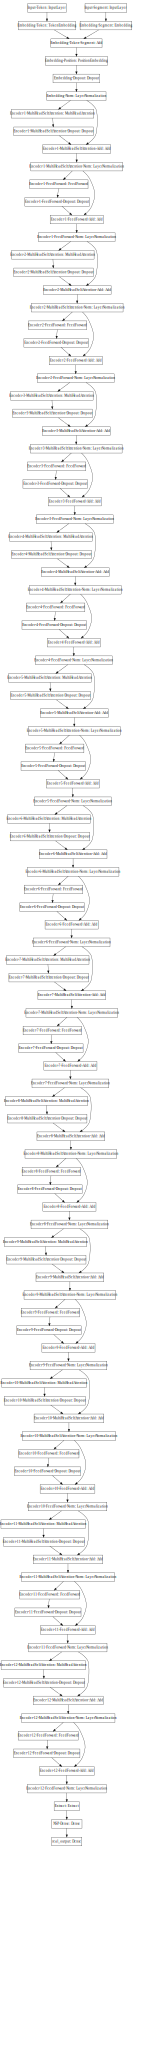

In [0]:
#SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

# 1) epoch =5

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=5, batch_size=16, verbose = 1, validation_data=(val_x, val_y), shuffle=True)
'''
123 / 45 [긍정부정]
epochs=5
seq_len = 256
batch_size=8
learning rate = 0.00001
optimizer=radam
'''

Train on 34297 samples, validate on 8575 samples
Epoch 1/5
34297/34297 [==============================] - 2365s 69ms/step - loss: 1.2824 - accuracy: 0.4070 - val_loss: 1.1510 - val_accuracy: 0.4756
Epoch 2/5
34297/34297 [==============================] - 2349s 68ms/step - loss: 1.1041 - accuracy: 0.4995 - val_loss: 1.0727 - val_accuracy: 0.5121
Epoch 3/5
34297/34297 [==============================] - 2348s 68ms/step - loss: 0.9864 - accuracy: 0.5588 - val_loss: 1.0251 - val_accuracy: 0.5391
Epoch 4/5
34297/34297 [==============================] - 2348s 68ms/step - loss: 0.8832 - accuracy: 0.6106 - val_loss: 1.0503 - val_accuracy: 0.5440
Epoch 5/5
34297/34297 [==============================] - 2348s 68ms/step - loss: 0.7670 - accuracy: 0.6709 - val_loss: 1.1466 - val_accuracy: 0.5419


'\n123 / 45 [긍정부정]\nepochs=5\nseq_len = 256\nbatch_size=8\nlearning rate = 0.00001\noptimizer=radam\n'

In [0]:
bert_model.save_weights(path+"/bert_cat_epoch5_batch16.h5")

In [0]:
os.listdir(path)

['multi_cased_L-12_H-768_A-12.zip',
 'multi_cased_L-12_H-768_A-12.zip.1',
 'Colab Notebooks',
 'FinTech_Ch3_Classification.ipynb',
 '[핀테크 과정] 머신러닝 팀플',
 'Untitled0.ipynb',
 'whatever',
 'handson_chap4_정하련',
 'FinTech_Chapter8_Dimensionality_Reduction.ipynb',
 'FinTech_Ch6.ipynb',
 'ml,dl',
 'Project_example1.ipynb',
 'Project_example2.ipynb',
 '이노베이션',
 '통계_데이터사이언스',
 'oversampling',
 '통계_류근관교수님',
 'feature selection',
 'summation',
 'random_function',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 'FinalBayesian_normal.ipynb의 사본의 사본',
 'DL',
 '.ipynb_checkpoints',
 'DL_project',
 'bert',
 'bert_pn_epoch5_batch16.h5',
 'multi_cased_L-12_H-768_A-12.zip.2',
 'bert_cat_epoch5_batch16.h5']

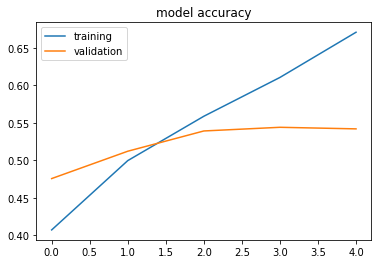

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('model accuracy')
plt.show()

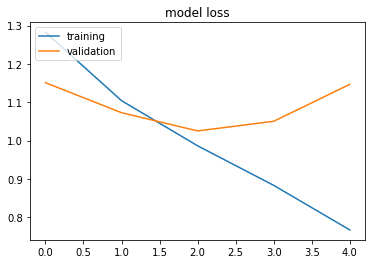

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('model loss')
plt.show()

In [0]:
#예측
preds = bert_model.predict(test_x)

In [0]:
# 부정이면 0, 긍정이면 1 출력
preds

array([[3.5348677e-04, 3.3801899e-03, 8.4336340e-02, 8.0372626e-01,
        1.0820368e-01],
       [6.5428531e-04, 2.8500913e-03, 2.5154162e-02, 7.1687657e-01,
        2.5446486e-01],
       [9.4117556e-04, 1.4194490e-02, 3.6403987e-01, 6.0022062e-01,
        2.0603808e-02],
       ...,
       [3.3180767e-03, 3.7402485e-02, 5.3874606e-01, 3.6036417e-01,
        6.0169235e-02],
       [6.6496073e-03, 1.3228486e-01, 7.6271617e-01, 9.2612252e-02,
        5.7370807e-03],
       [6.2798645e-04, 5.8859104e-04, 1.9649530e-03, 7.8826815e-02,
        9.1799170e-01]], dtype=float32)

In [0]:
preds_list = []
for i in range(0, len(preds)):
  preds_list.append([np.where(preds[i] == a) for a in preds[i] if a == max(preds[i])][0][0][0]) 

In [0]:
preds_list

[3,
 3,
 3,
 4,
 2,
 2,
 3,
 3,
 3,
 1,
 2,
 3,
 1,
 3,
 4,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 4,
 2,
 2,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 2,
 4,
 4,
 3,
 3,
 4,
 3,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 1,
 0,
 2,
 2,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 4,
 1,
 3,
 1,
 3,
 2,
 3,
 4,
 4,
 4,
 3,
 4,
 3,
 3,
 4,
 3,
 2,
 3,
 1,
 2,
 4,
 1,
 4,
 4,
 3,
 3,
 2,
 1,
 2,
 3,
 3,
 4,
 3,
 3,
 2,
 3,
 3,
 2,
 1,
 2,
 3,
 3,
 3,
 4,
 3,
 2,
 3,
 4,
 3,
 4,
 2,
 4,
 3,
 4,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 2,
 4,
 4,
 4,
 2,
 3,
 3,
 3,
 4,
 4,
 1,
 3,
 3,
 3,
 3,
 2,
 4,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 3,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 1,
 3,
 3,
 4,
 3,
 3,
 2,
 3,
 3,
 4,
 2,
 3,
 4,
 1,
 4,
 2,
 3,
 1,
 4,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 3,
 2,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 4,
 2,
 3,
 4,
 4,
 4,
 2,
 4,
 4,


In [0]:
y_true = test_y
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.80      0.04      0.08       179
           1       0.46      0.29      0.35       792
           2       0.47      0.43      0.45      1979
           3       0.53      0.62      0.57      4203
           4       0.66      0.49      0.56      3565

   micro avg       0.55      0.51      0.53     10718
   macro avg       0.58      0.37      0.40     10718
weighted avg       0.56      0.51      0.52     10718
 samples avg       0.51      0.51      0.51     10718



In [0]:
results = bert_model.evaluate(test_x, test_y)
print('Test accuracy: ', results[1])

InvalidArgumentError: ignored

# t-SNE visualization (epoch = 5)


In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights('/content/drive/My Drive/bert_pn_epoch5_batch16.h5')

In [0]:
def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [0]:
bert_feature = get_feature_map(bert_model)

In [0]:
#SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

마지막 부분을 보시면 768개의 피처가 반환되게 됩니다.

테스트 데이터의 피처들을 반환하고, TSNE 임베딩 플롯을 그려보도록 하겠습니다.

In [0]:
bert_weight_list = bert_feature.predict(test_x)

In [0]:
bert_weight_list

array([[-0.50911224,  0.5552889 ,  0.12214231, ..., -0.6839075 ,
         0.04532235,  0.24291116],
       [-0.40818682,  0.12225687,  0.18262868, ...,  0.09153905,
         0.12701288, -0.43124053],
       [-0.18209817, -0.1272908 ,  0.21382579, ...,  0.20294891,
         0.11751654, -0.17439687],
       ...,
       [-0.6407305 ,  0.45554218,  0.07485311, ..., -0.6253978 ,
         0.07335405,  0.14117064],
       [-0.15328379, -0.0264047 ,  0.2716954 , ..., -0.05826389,
         0.27475992, -0.19081978],
       [-0.50378466,  0.47546995,  0.09353644, ..., -0.70401514,
        -0.02505752,  0.30353498]], dtype=float32)

마지막 768 차원을 PCA를 사용하여 256차원으로 줄여줍니다.
그 다음 TSNE 알고리즘을 활용하여 3차원으로 축소해 줍니다.
TSNE 알고리즘은 유사한 것끼리 클러스터를 만들어 주는 역할을 합니다.

In [0]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[ -2.6476877 , -10.76428   ,  -7.29882   ],
       [ 13.9558735 ,   5.7170324 ,   2.557922  ],
       [ 12.387652  ,  -5.9869967 ,   7.053389  ],
       ...,
       [ -9.147529  ,  -0.7428068 , -10.46525   ],
       [ 12.842695  ,  -3.82685   ,  -0.72263795],
       [ -0.8149569 , -12.4063225 ,   2.8507326 ]], dtype=float32)

bert 임베딩을 pickle 모듈을 활용하여 저장해 줍니다.  

추후 재사용에 쓸 예정입니다.

In [0]:
with open(path+"/bertembedding.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

저장하였던 임베딩 파일을 로드합니다.

In [0]:
with open(path+"/bertembedding.pkl", "rb") as f:
  bert_embedded = pickle.load(f)

3D로 그리기 위해 matplotlib 모듈들을 로드합니다.

In [0]:
y_test

33781    1
26792    1
46639    0
17702    1
10969    1
        ..
8111     0
40816    0
11505    1
9198     0
8087     1
Name: label, Length: 10718, dtype: int64

In [0]:
def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[y_test==label,0], bert_embedded[y_test==label,1], bert_embedded[y_test==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

긍정(1)과 부정(0)의 임베딩이 잘 되는지 확인해 봅니다.  

긍정 부분의 클러스터와 부정구간의 클러스터가 잘 구분되는 것을 확인하실 수 있습니다.

rot1:-180 rot2:-180


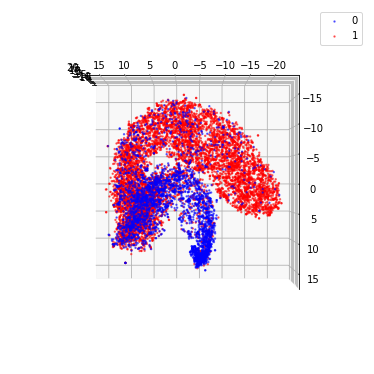

rot1:-135 rot2:-180


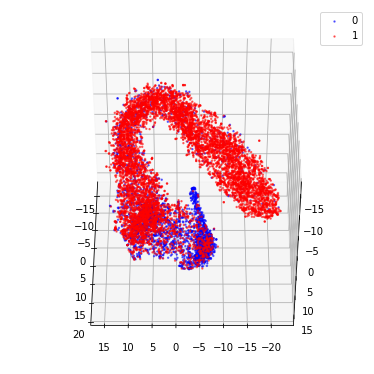

rot1:-90 rot2:-180


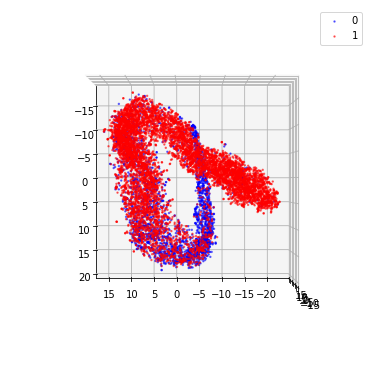

rot1:-45 rot2:-180


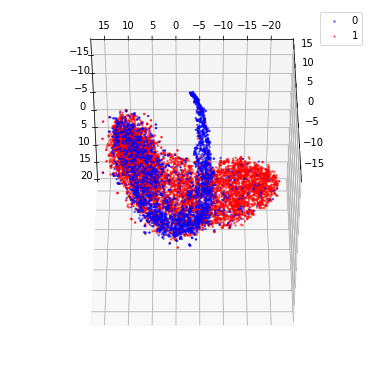

rot1:0 rot2:-180


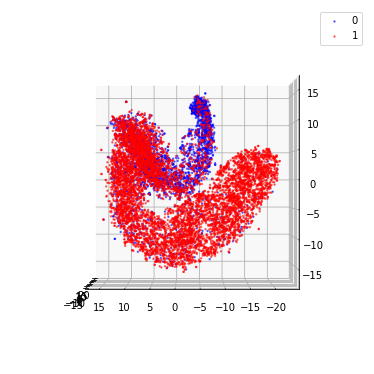

rot1:45 rot2:-180


rot1:90 rot2:-180


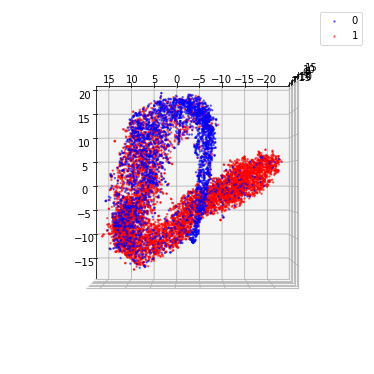

rot1:135 rot2:-180


rot1:-180 rot2:-135


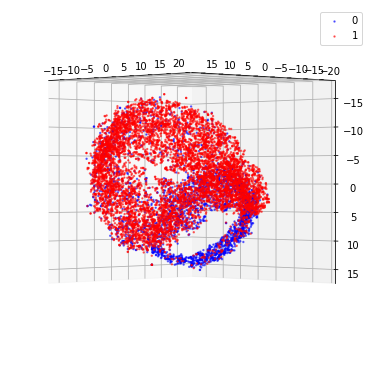

rot1:-135 rot2:-135


rot1:-90 rot2:-135


rot1:-45 rot2:-135


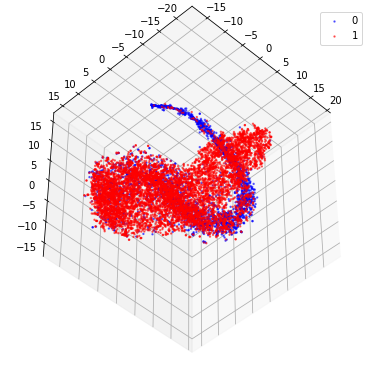

rot1:0 rot2:-135


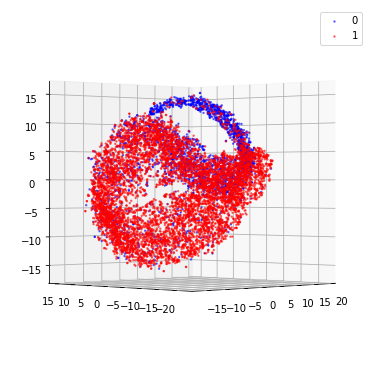

rot1:45 rot2:-135


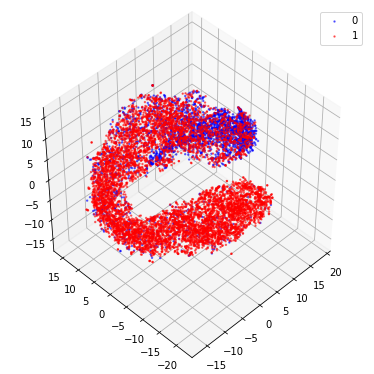

rot1:90 rot2:-135


rot1:135 rot2:-135


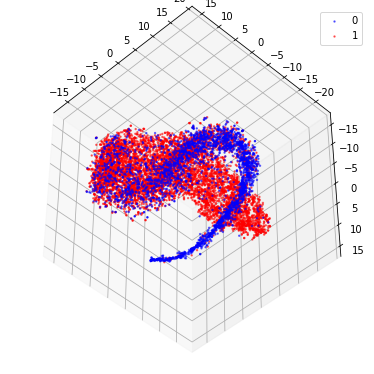

rot1:-180 rot2:-90


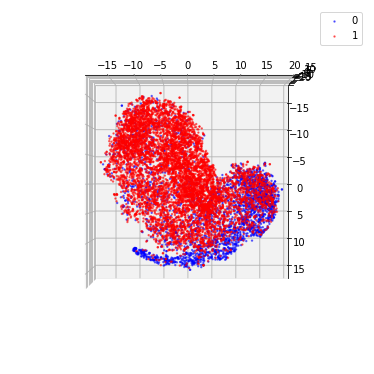

rot1:-135 rot2:-90


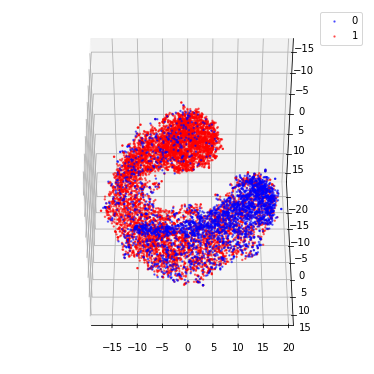

rot1:-90 rot2:-90


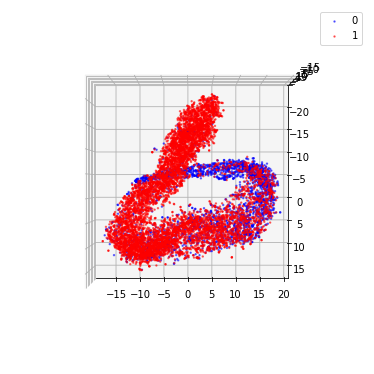

rot1:-45 rot2:-90


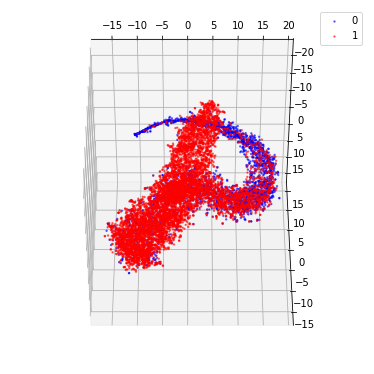

rot1:0 rot2:-90


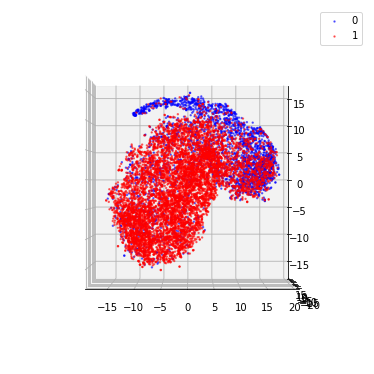

rot1:45 rot2:-90


rot1:90 rot2:-90


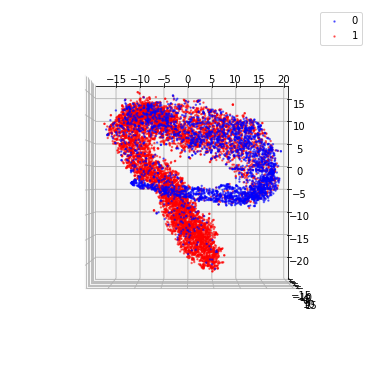

rot1:135 rot2:-90


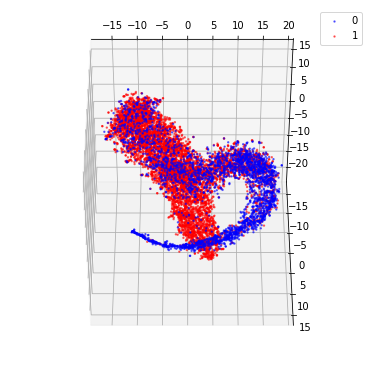

rot1:-180 rot2:-45


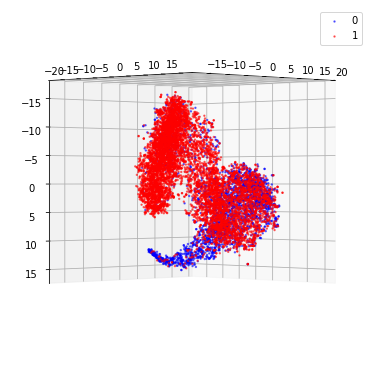

rot1:-135 rot2:-45


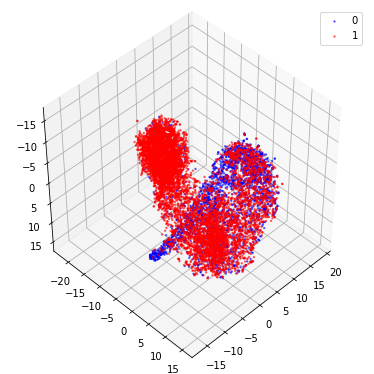

rot1:-90 rot2:-45


rot1:-45 rot2:-45


rot1:0 rot2:-45


rot1:45 rot2:-45


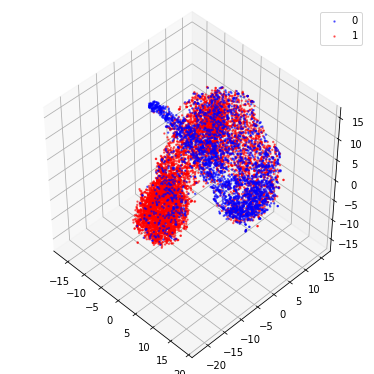

rot1:90 rot2:-45


rot1:135 rot2:-45


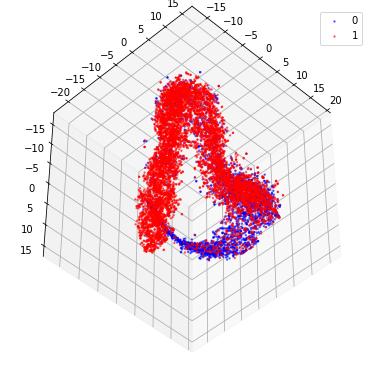

rot1:-180 rot2:0


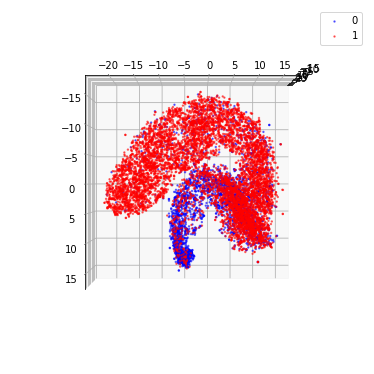

rot1:-135 rot2:0


rot1:-90 rot2:0


rot1:-45 rot2:0


rot1:0 rot2:0


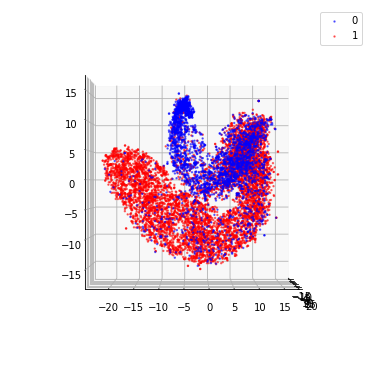

rot1:45 rot2:0


rot1:90 rot2:0


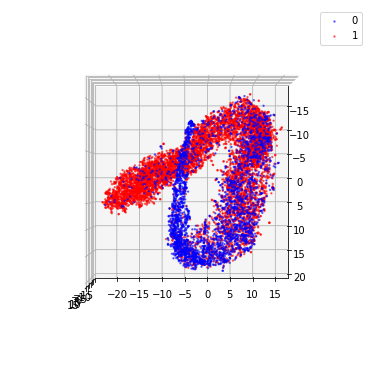

rot1:135 rot2:0


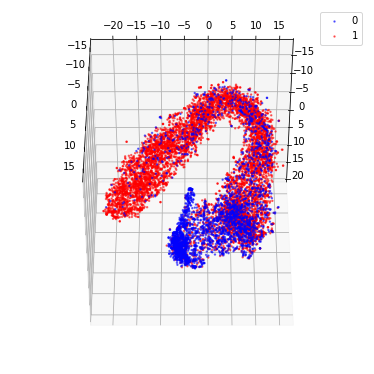

rot1:-180 rot2:45


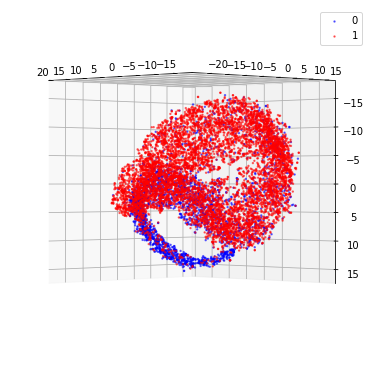

rot1:-135 rot2:45


rot1:-90 rot2:45


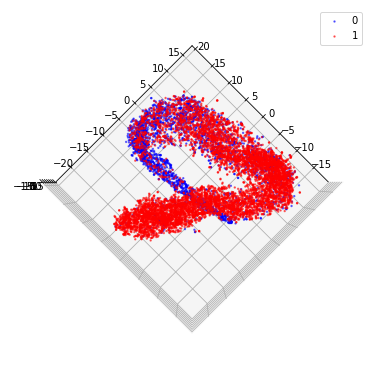

rot1:-45 rot2:45


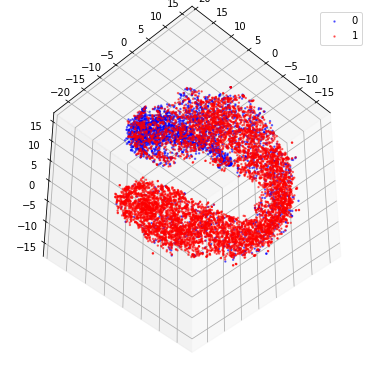

rot1:0 rot2:45


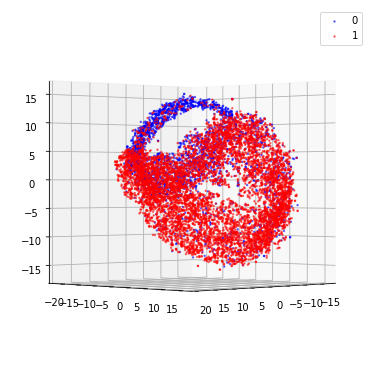

rot1:45 rot2:45


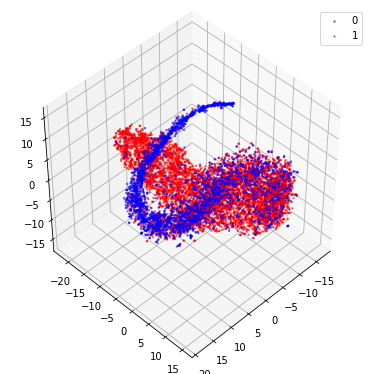

rot1:90 rot2:45


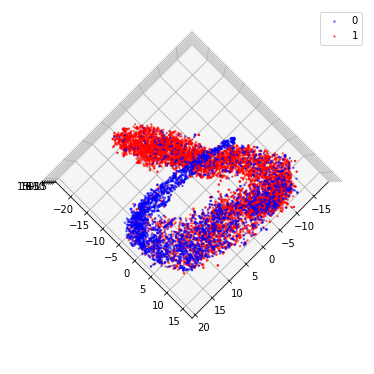

rot1:135 rot2:45


rot1:-180 rot2:90


rot1:-135 rot2:90


rot1:-90 rot2:90


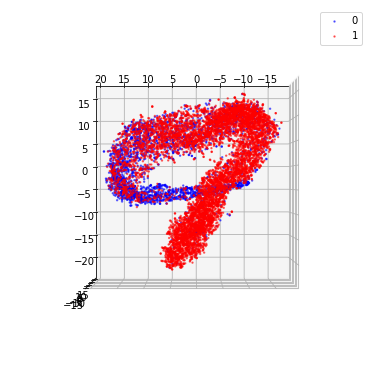

rot1:-45 rot2:90


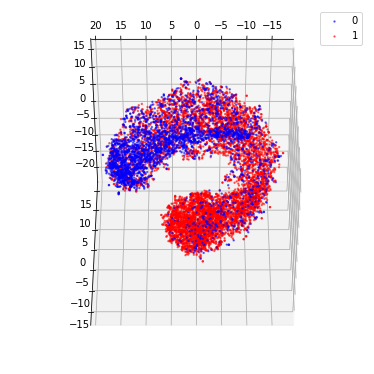

rot1:0 rot2:90


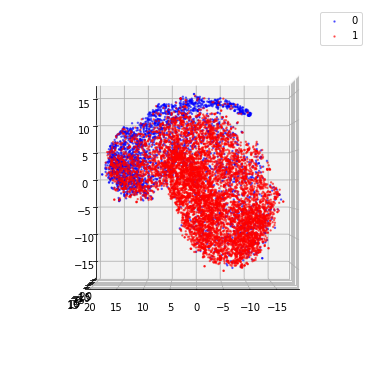

rot1:45 rot2:90


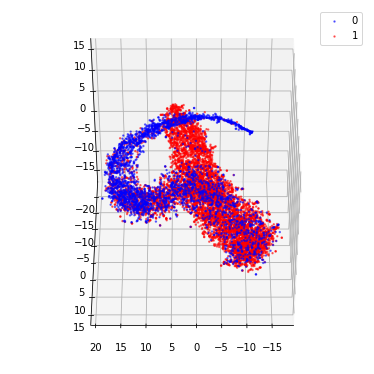

rot1:90 rot2:90


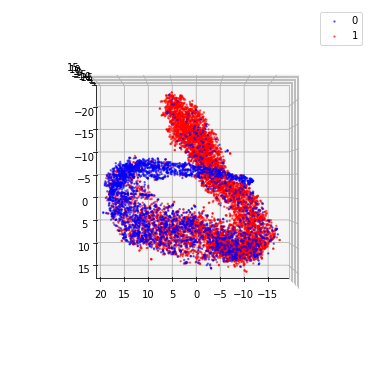

rot1:135 rot2:90


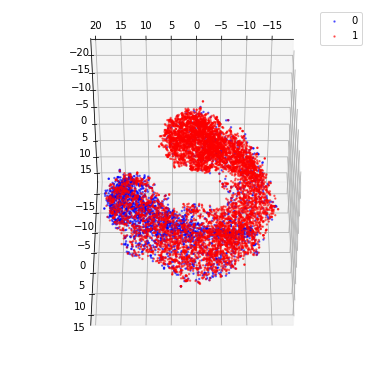

rot1:-180 rot2:135


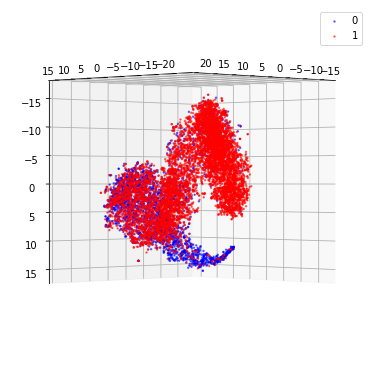

rot1:-135 rot2:135


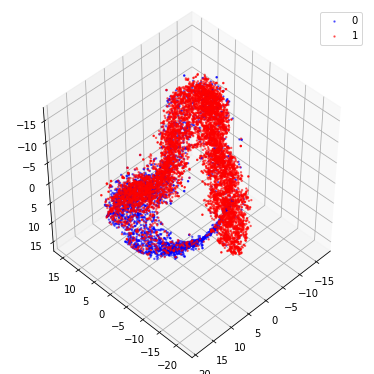

rot1:-90 rot2:135


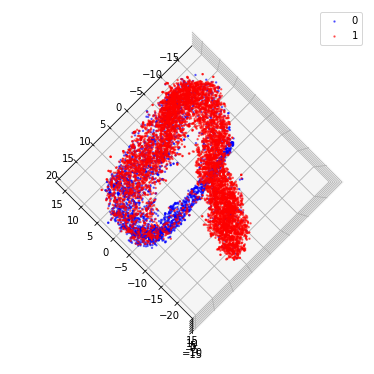

rot1:-45 rot2:135


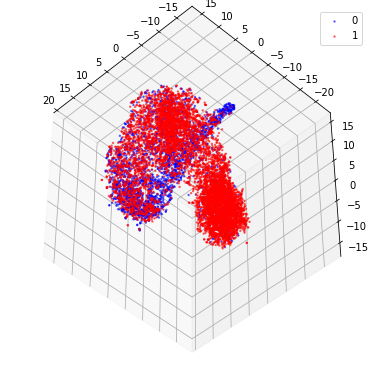

rot1:0 rot2:135


rot1:45 rot2:135


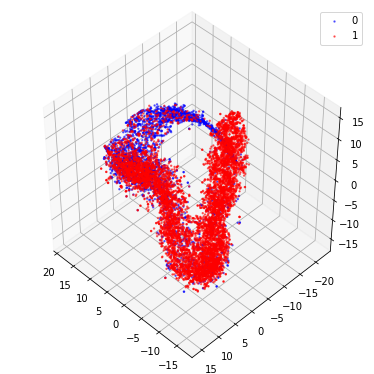

rot1:90 rot2:135


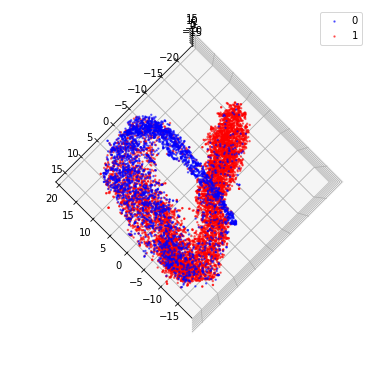

rot1:135 rot2:135


In [0]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
  
    get_tsne_plot(i, j)
